In [1]:
# Import required libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import shufflenet_v2_x1_0
from sklearn.metrics import accuracy_score
from PIL import Image
import matplotlib.pyplot as plt

# 1. Load and Prepare the Dataset
# Define transforms for your dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# Use ImageFolder to load your custom dataset (change the path to your dataset)
train_dataset = datasets.ImageFolder(root= r'E:\soundarya\crop recommentation\pest detection audio\pest detection audio\plant species\training', transform=transform)
val_dataset = datasets.ImageFolder(root= r'E:\soundarya\crop recommentation\pest detection audio\pest detection audio\plant species\testing', transform=transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 2. Initialize ShuffleNet Model
num_classes = len(train_dataset.classes)  # Get the number of classes
model = shufflenet_v2_x1_0(pretrained=True)  # Load pre-trained ShuffleNet
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify the final layer for our dataset

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 3. Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 4. Training Loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# 5. Validation Loop
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Validation Accuracy: {100 * correct / total:.2f}%')

# 6. Save the Model
torch.save(model.state_dict(), './shufflenet_model.pth')

# 7. Prediction Function
def predict(image_path, model, transform, class_names):
    model.eval()
    image = Image.open(image_path)  # Open the image
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)
    predicted_class = class_names[predicted.item()]  # Get the class name
    return predicted_class



C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/15], Loss: 1.6787
Epoch [2/15], Loss: 1.2432
Epoch [3/15], Loss: 1.2410
Epoch [4/15], Loss: 1.3111
Epoch [5/15], Loss: 0.7177
Epoch [6/15], Loss: 0.6170
Epoch [7/15], Loss: 0.3054
Epoch [8/15], Loss: 1.1835
Epoch [9/15], Loss: 0.3653
Epoch [10/15], Loss: 0.3723
Epoch [11/15], Loss: 0.1751
Epoch [12/15], Loss: 0.1313
Epoch [13/15], Loss: 0.0205
Epoch [14/15], Loss: 0.0936
Epoch [15/15], Loss: 0.3985
Validation Accuracy: 97.52%


Predicted Class: pituitary_tumor


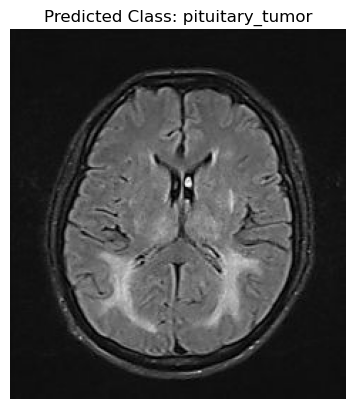

In [3]:
# Example usage of prediction
image_path = r'F:\ABDUL\ABDUL 2024\BRAIN_DAMAGE\Brain-UI\train\pituitary_tumor\image(10).jpg'  # Path to an image
predicted_class = predict(image_path, model, transform, train_dataset.classes)
print(f'Predicted Class: {predicted_class}')

# 8. Display the Image with the Predicted Class
def display_image_with_prediction(image_path, predicted_class):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

# Display the image with its predicted class
display_image_with_prediction(image_path, predicted_class)

                  precision    recall  f1-score   support

    glioma_tumor       1.00      1.00      1.00        15
meningioma_tumor       0.99      1.00      0.99        91
        no_tumor       1.00      1.00      1.00        56
 pituitary_tumor       1.00      0.99      0.99       100

        accuracy                           1.00       262
       macro avg       1.00      1.00      1.00       262
    weighted avg       1.00      1.00      1.00       262



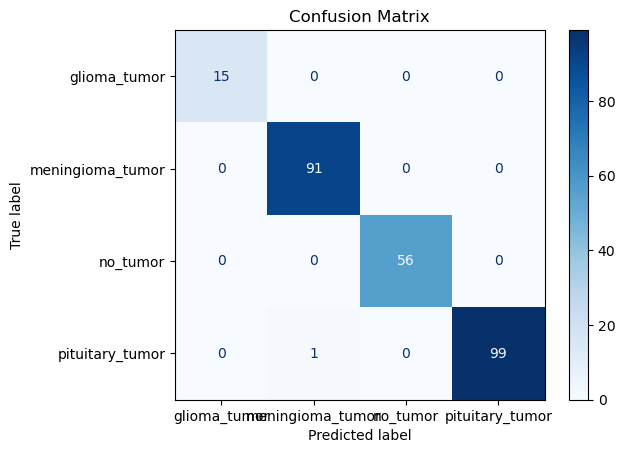

In [10]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Gather predictions and true labels
all_predictions = []
all_labels = []

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Classification Report
report = classification_report(all_labels, all_predictions, target_names=train_dataset.classes)
print(report)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Epoch [1/15], Train Loss: 0.0900, Validation Loss: 0.1096
Epoch [2/15], Train Loss: 0.1469, Validation Loss: 0.0363
Epoch [3/15], Train Loss: 0.1455, Validation Loss: 0.0334
Epoch [4/15], Train Loss: 0.0878, Validation Loss: 0.0242
Epoch [5/15], Train Loss: 0.0931, Validation Loss: 0.0112
Epoch [6/15], Train Loss: 0.2182, Validation Loss: 0.0690
Epoch [7/15], Train Loss: 0.2125, Validation Loss: 0.0656
Epoch [8/15], Train Loss: 0.0974, Validation Loss: 0.0295
Epoch [9/15], Train Loss: 0.0659, Validation Loss: 0.0163
Epoch [10/15], Train Loss: 0.0337, Validation Loss: 0.0092
Epoch [11/15], Train Loss: 0.0270, Validation Loss: 0.0069
Epoch [12/15], Train Loss: 0.0118, Validation Loss: 0.0049
Epoch [13/15], Train Loss: 0.0166, Validation Loss: 0.0040
Epoch [14/15], Train Loss: 0.0207, Validation Loss: 0.0023
Epoch [15/15], Train Loss: 0.0286, Validation Loss: 0.0023


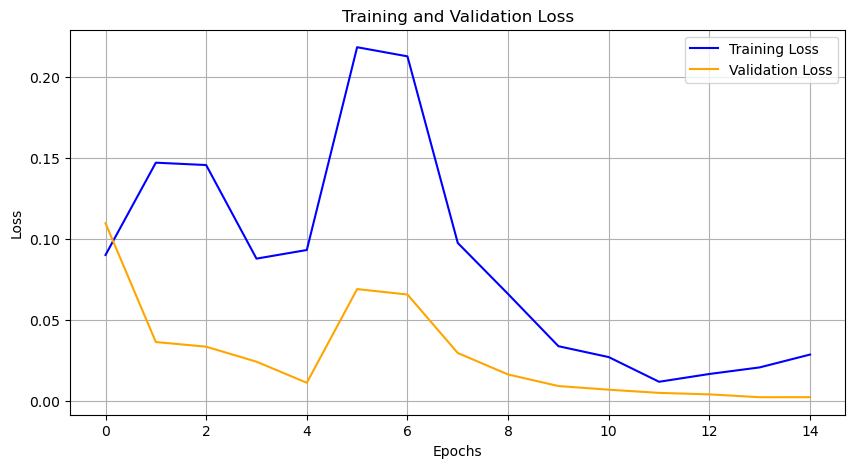

In [11]:
import matplotlib.pyplot as plt

# Initialize lists to store the loss values
train_losses = []
val_losses = []

# 4. Training Loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average training loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Loop
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

    # Calculate average validation loss
    avg_val_loss = val_running_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}')

# 8. Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
